In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re

In [1]:
# Get a list of all the urls for the avalanche reports for Salt-Lake
page_numbers = range(17) #0 - 16 inclusive
url_base = 'https://utahavalanchecenter.org/archives/forecasts/salt-lake?page='
urls = [url_base + str(page_number) for page_number in page_numbers]

sub_urls = []


# REQUESTS
for website in urls:
    response = requests.get(website)
    soup = BeautifulSoup(response.content, 'html.parser')
    links = soup.find_all('a')
    for link in links:
        print(link.get('href'))
        sub_urls.append(link.get('href'))

pd.DataFrame(sub_urls).to_csv('sub_urls.csv')


https://store.utahavalanchecenter.org/collections/events-1
https://www.mammut.com/
/
/observations-avalanches/submit
None
/forecast/logan
/forecast/ogden
/forecast/salt-lake
/forecast/provo
/forecast/uintas
/forecast/skyline
/forecast/moab
/forecast/abajos
/node/13549
/archives/forecasts
/node/41482
/node/13652
/observations
/avalanches
/avalanches/fatalities
http://wasatchbackcountryskiing.com/
/node/16726
/node/69813
/node/70741
/node/69815
/node/70744
https://store.utahavalanchecenter.org/collections/events-1
https://store.utahavalanchecenter.org/
/node/21578
/node/13544
https://utahavalanchecenter.org/core-values
/node/13545
/node/13546
/node/39841
/node/39875
/node/16727
/user/login
/node/39859
/join
/forecast/logan
/forecast/ogden
/forecast/salt-lake
/forecast/provo
/forecast/uintas
/forecast/skyline
/forecast/moab
/forecast/abajos
/node/13549
/archives/forecasts
/node/41482
/node/13652
/observations
/avalanches
/avalanches/fatalities
http://wasatchbackcountryskiing.com/
/node/16

In [14]:
# Clean the data and put it into a dataframe
df = pd.read_csv('sub_urls.csv')
df.columns = ['index', 'url']

# filter urls with prefix 'https://utahavalanchecenter.org/forecast/salt-lake/'
df = df[df['url'].str.startswith('https://utahavalanchecenter.org/forecast/salt-lake/')]
df = df.reset_index(drop=True)
df['url'] = df['url'].str.replace('https://utahavalanchecenter.org/forecast/salt-lake/', '')


FileNotFoundError: [Errno 2] No such file or directory: 'sub_urls.csv'

In [11]:
# More cleaning
prefix = '/forecast/salt-lake/'
df = df.fillna('') # fill NaNs with empty string
df = df[df['url'].str.startswith(prefix)]
df = df.reset_index(drop=True)
base = 'https://utahavalanchecenter.org'
df['url'] = base + df['url']

NameError: name 'df' is not defined

In [15]:
# Drop duplicates and save to csv
df.drop_duplicates(subset=['url'], inplace=True)
df = df.reset_index(drop=True)
df.to_csv('daily_reports_urls.csv', index=False)

In [16]:
df = pd.read_csv('resources/daily_reports_urls.csv')

In [18]:
def get_page_source(url):
    response = requests.get(url)
    page_source = response.content
    return page_source

In [65]:
page_source = get_page_source('https://utahavalanchecenter.org/forecast/salt-lake/2/27/2023')

In [66]:
# first link will be the overall forecast image
def get_rose_image_links(page_source):
    # find all links that start with '/sites/default/files/forecast/'
    links = re.findall(r'<img.*?src="/(sites/default/files/forecast/.*?)">', page_source.decode('utf-8'))
    # append 'https://utahavalanchecenter.org' to the beginning of each link
    links = ['https://utahavalanchecenter.org/' + link for link in links]
    return links

links = get_rose_image_links(page_source)


In [21]:
def get_color(image, pixel_location):
    return image.getpixel(pixel_location)

In [22]:
def load_image(url):
    return Image.open(requests.get(url, stream=True).raw)

In [23]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [24]:
def classify_color(rgba):
    color_map = {
        'red': (237, 28, 36, 255), # High
        'orange': (247, 148, 30, 255), # Considerable
        'yellow': (255, 242, 0, 255), # Moderate
        'green': (80, 184, 72, 255), # Low
        'blue': (68, 187, 238, 255), #
        'gray': (192, 192, 192, 255), # 
        'white': (255, 255, 255, 255), #'  
        'black': (0, 0, 0, 255), # Extreme
        'transparent': (0, 0, 0, 0) #
    }
    # Get the color with the smallest distance from the given color
    from scipy.spatial import distance
    distances = []
    for color in color_map.values():
        distances.append(distance.euclidean(rgba, color))
    min_index = np.argmin(distances)
    return list(color_map.keys())[min_index]

In [25]:
def get_forecast_level(image, pixel_locations):
    # Get the color at each pixel for a list of pixel locations
    colors = []
    for location in pixel_locations:
        rgba = get_color(image, location)
        color = classify_color(rgba)
        colors.append(color)
    return colors

In [26]:
def get_forecast_from_image(image):
    pixel_map = {
    'high': {
        'N': (200, 132),
        'NE': (220, 132),
        'E': (240, 154),
        'SE': (220, 176),
        'S': (200, 176),
        'SW': (180, 176),
        'W': (160, 154),
        'NW': (180, 132)
    },
    'mid': {
        'N': (200, 110),
        'NE': (240, 110),
        'E': (270, 154),
        'SE': (240, 220),
        'S': (200, 230),
        'SW': (140, 198),
        'W': (120, 154),
        'NW': (140, 110),
    },
    'low': {
        'N': (200, 66),
        'NE': (300, 110),
        'E': (320, 176),
        'SE': (280, 264),
        'S': (200, 286),
        'SW': (100, 242),
        'W': (80, 176),
        'NW': (100, 110),
    },    
}
    forecast = {}
    for level, pixel_locations in pixel_map.items():
        forecast[level] = get_forecast_level(image, pixel_locations.values())
    return forecast

In [27]:
def get_forecast_from_url(image_url):
    image = load_image(image_url)
    forecast = get_forecast_from_image(image)
    return forecast


In [46]:
def get_danger_level(level_forecast):
    danger_map = {
        'black': 4,
        'red': 3,
        'orange': 2,
        'yellow': 1,
        'green': 0,
    }
    dangers = [danger_map[danger] for danger in level_forecast]
    for key, value in danger_map.items():
        if value == max(dangers):
            return key
    return None

In [58]:
image = load_image(links[1])

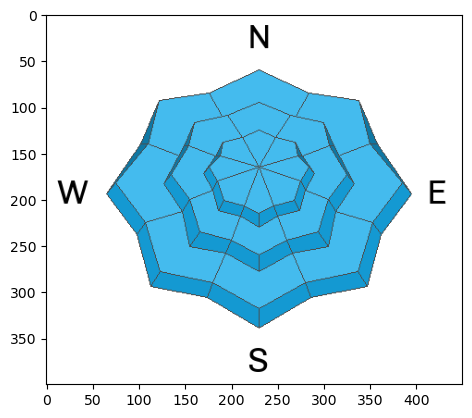

In [59]:
show_image(image)

In [60]:
# REQUEST
f = get_forecast_from_image(image)
f


{'high': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
 'mid': ['blue', 'blue', 'green', 'blue', 'blue', 'blue', 'blue', 'blue'],
 'low': ['transparent',
  'blue',
  'blue',
  'blue',
  'blue',
  'blue',
  'green',
  'transparent']}

In [71]:
def extract_avalanche_problems(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    divs = soup.find_all('div', string=lambda t: t and 'Avalanche Problem #' in t)
    problems = []
    for div in divs:
        h5 = div.find_next_sibling('h5')
        if h5:
            problems.append(h5.text)
    return problems

def extract_likelihood_numbers(page_source):
    # Find all image links that contain 'likelihood' in the URL
    links = re.findall(r'<img.*?src="(.*?likelihood.*?)".*?>', page_source.decode('utf-8'))
    # Extract the number from each URL using regular expressions
    numbers = [re.search(r'likelihood_(\d+)\.jpg', link).group(1) for link in links]
    return numbers

def extract_size_numbers(page_source):
    # Find all image links that contain 'size' in the URL
    links = re.findall(r'<img.*?src="(.*?size.*?)".*?>', page_source.decode('utf-8'))
    # Extract the number from each URL using regular expressions
    numbers = [re.search(r'size_(\d+)\.jpg', link).group(1) for link in links]
    return numbers

def get_avalanche_problems(page_source):
    problems = extract_avalanche_problems(page_source)
    likelihood_numbers = extract_likelihood_numbers(page_source)
    size_numbers = extract_size_numbers(page_source)
    return {
        'problems': problems,
        'likelihood_numbers': likelihood_numbers,
        'size_numbers': size_numbers,
    }

In [72]:
get_avalanche_problems(page_source)

{'problems': ['New Snow', 'Wind Drifted Snow'],
 'likelihood_numbers': ['02', '03'],
 'size_numbers': ['02', '02']}

In [75]:
def get_avalanche(url):
    page_source = get_page_source(url)
    links = get_rose_image_links(page_source)
    forecast = get_forecast_from_url(links[0])
    level_forecasts = [forecast['high'], forecast['mid'], forecast['low']]
    # get avalanche problems roses
    problems = get_avalanche_problems(page_source)
    return {
        'forecast': forecast,
        'level_forecasts': level_forecasts,
        'problems': problems,
    }

In [76]:
get_avalanche('https://utahavalanchecenter.org/forecast/salt-lake/3/2/2023')

{'forecast': {'high': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'mid': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'low': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']},
 'level_forecasts': [['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']],
 'problems': {'problems': ['Wind Drifted Snow', 'New Snow', 'Wet Snow'],
  'likelihood_numbers': ['02', '02', '02'],
  'size_numbers': ['04', '03', '02']}}

In [ ]:
avalanche = pd.DataFrame(columns=['date', 'HN', 'HNE', 'HE', 'HSE', 'HS', 'HSW', 'HW', 'HNW', 
                                               'MN', 'MNE', 'ME', 'MSE', 'MS', 'MSW', 'MW', 'MNW',
                                               'LN', 'LNE', 'LE', 'LSE', 'LS', 'LSW', 'LW', 'LNW',
                                               'high', 'mid', 'low',
                                                'problem_1', 'likelihood_1', 'size_1',
                                                'problem_2', 'likelihood_2', 'size_2',
                                                'problem_3', 'likelihood_3', 'size_3',])